In [ ]:
import sys
sys.path.append('/net/mulan/home/huiwann/spatial/SVC/')
import tifffile
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
from model.utils import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = '/net/mulan/home/huiwann/spatial/SVC/' 
dataset = 'data/seqfish' 

gene_names = []
cell_names = []

with open(f'{data_path}{dataset}/gene_names.txt', 'r') as file:
    for line in file:
        gene_names.append(line.strip())

with open(f'{data_path}{dataset}/cell_names.txt', 'r') as file:
    for line in file:
        cell_names.append(line.strip())

In [3]:
batch='3'
train_indices,test_indices = [],[]
for i in range(len(cell_names)):
    if f'-{batch}' in cell_names[i]:
        test_indices.append(i)
    else:
        train_indices.append(i)
test_cell_names = np.array(cell_names)[test_indices]

In [4]:
prediction_49_genes_mu = np.load(f"{data_path}output/seqfish/prediction_49_genes_mu.npz")["prediction"]
prediction_49_genes_r = np.load(f"{data_path}output/seqfish/prediction_49_genes_r.npz")["prediction"]

In [5]:
np.random.seed(2025)
count_data = np.zeros((prediction_49_genes_mu.shape[0],prediction_49_genes_mu.shape[1], 48, 48))
for i in tqdm(range(prediction_49_genes_mu.shape[0])):
    for j in range(prediction_49_genes_mu.shape[1]):

        cell_gene_mu = prediction_49_genes_mu[i,j]
        cell_gene_r = prediction_49_genes_r[i,j]
        cell_gene_mu = np.repeat(cell_gene_mu/4, 4, axis=0)
        cell_gene_mu = np.repeat(cell_gene_mu/4, 4, axis=1)
        
        cell_gene_r = np.repeat(cell_gene_r, 4, axis=1)
        cell_gene_r = np.repeat(cell_gene_r, 4, axis=0)
        mask = cell_gene_r > 0
        count_data_0 = np.zeros((48,48))
        n = cell_gene_r[mask]
        p = cell_gene_r[mask] / (cell_gene_r[mask] + cell_gene_mu[mask])
        count_data_0[mask] = np.random.negative_binomial(n, p)
        count_data[i,j] = count_data_0
print("shape of count_data:",count_data.shape)

100%|██████████| 14/14 [00:00<00:00, 128.61it/s]

shape of count_data: (14, 49, 48, 48)


In [6]:
# seqfish+ genes in extended data fig 3
protrusion20List = ['Cyb5r3', 'Sh3pxd2a', 'Ddr2', 'Kif1c', 'Kctd10', 
                    'Dynll2', 'Arhgap11a', 'Dync1li2', 'Palld', 'Naa50']

nuclear20List = ['Col1a1', 'Fn1', 'Fbln2', 'Col6a2', 'Bgn',  
                 'Nid1', 'Lox', 'P4hb', 'Aebp1', 'Emp1',
                 'Col5a1', 'Sdc4', 'Postn', 'Col3a1', 'Pdia6',
                 'Col5a2', 'Itgb1', 'Calu', 'Pdia3']
                 
cytoplasm20List = ['Ddb1', 'Myh9', 'Actn1', 'Tagln2', 'Kpnb1',
                   'Hnrnpf', 'Ppp1ca', 'Hnrnpl', 'Pcbp1', 'Tagln', 
                   'Fscn1', 'Psat1', 'Cald1', 'Snd1', 'Uba1',
                   'Hnrnpm', 'Cap1', 'Ssrp1', 'Ugdh', 'Caprin1']

selected_gene = protrusion20List+nuclear20List+cytoplasm20List

In [7]:
non_zero_df_pred = pd.DataFrame()
for i in tqdm(selected_gene):
    count_data_i = count_data[:,selected_gene.index(i)]
    non_zero_indices = np.argwhere(count_data_i != 0)
    non_zero_values = count_data_i[non_zero_indices[:, 0],  non_zero_indices[:, 1], non_zero_indices[:, 2]]

    center_x, center_y = 24,24
    x, y = non_zero_indices[:, 2], non_zero_indices[:, 1]
    ratio = np.sqrt((x+0.5 - center_x) ** 2 + (y+0.5 - center_y) ** 2)/24
    ratio = np.minimum(ratio, 1)
    angles = (np.degrees(np.arctan2(y+0.5 - center_y, x+0.5 - center_x))*2).round()/2
    cell = np.array(test_cell_names)[non_zero_indices[:, 0]]
    gene = np.repeat(i, len(non_zero_values))
    count = non_zero_values.flatten()

    # 创建DataFrame
    non_zero_df_pred_i = pd.DataFrame({
        'cell': cell,
        'gene': gene,
        'count': count,
        'x': x,
        'y': y,
        'ratio': ratio,
        'direction_vec': angles
    })

    non_zero_df_pred = pd.concat([non_zero_df_pred, non_zero_df_pred_i], axis=0)
print(non_zero_df_pred)


100%|██████████| 49/49 [00:00<00:00, 963.39it/s]

     cell     gene  count   x   y     ratio  direction_vec
0     1-3   Cyb5r3    1.0  25   0  0.981159          -86.5
1     1-3   Cyb5r3    1.0  35   1  1.000000          -63.0
2     1-3   Cyb5r3    1.0  36   4  0.965103          -57.5
3     1-3   Cyb5r3    1.0  23   5  0.771115          -91.5
4     1-3   Cyb5r3    1.0  38   5  0.979388          -52.0
..    ...      ...    ...  ..  ..       ...            ...
607  16-3  Caprin1    1.0  24  40  0.687816           88.5
608  16-3  Caprin1    1.0  28  40  0.712610           74.5
609  16-3  Caprin1    1.0  31  43  0.870524           69.0
610  16-3  Caprin1    1.0  25  44  0.856450           86.0
611  16-3  Caprin1    1.0  23  45  0.896076           91.5

[36114 rows x 7 columns]


In [8]:
df_cell_contour = pd.read_pickle(f"{data_path}{dataset}/cell_mask_contour_preprocessed.pkl")
print(df_cell_contour)
df_nuclear_contour = pd.read_pickle(f"{data_path}{dataset}/nuclear_mask_contour_preprocessed.pkl")
print(df_nuclear_contour)

     cell     x     y  centerX  centerY  direction_vec  distance_to_center
0     0-0   521   496     1079      724         -158.0          602.783543
1     0-0   519   496     1079      724         -158.0          604.635427
2     0-0   517   494     1079      724         -157.5          607.242950
3     0-0   515   494     1079      724         -158.0          609.094410
4     0-0   513   492     1079      724         -157.5          611.702542
..    ...   ...   ...      ...      ...            ...                 ...
387  9-16  1980  1288     1682     1383          -17.5          312.776278
388  9-16  1984  1288     1682     1383          -17.5          316.589640
389  9-16  1992  1284     1682     1383          -17.5          325.424338
390  9-16  2000  1280     1682     1383          -18.0          334.264865
391  9-16  2024  1268     1682     1383          -18.5          360.817128

[86309 rows x 7 columns]
     cell     x     y  centerX  centerY
0     0-0  1051   631     1079    

In [9]:
non_zero_df_pred['centerX'] = 0
non_zero_df_pred['centerY'] = 0
for cell in tqdm(non_zero_df_pred.cell.unique()):
    cell_center_x = df_cell_contour.centerX[df_cell_contour.cell == cell].values[0]
    cell_center_y = df_cell_contour.centerY[df_cell_contour.cell == cell].values[0]

    non_zero_df_pred.loc[non_zero_df_pred.cell == cell,'centerX'] = cell_center_x
    non_zero_df_pred.loc[non_zero_df_pred.cell == cell,'centerY'] = cell_center_y
print(non_zero_df_pred)    

100%|██████████| 14/14 [00:00<00:00, 89.75it/s]

     cell     gene  count   x   y     ratio  direction_vec  centerX  centerY
0     1-3   Cyb5r3    1.0  25   0  0.981159          -86.5     1026     1173
1     1-3   Cyb5r3    1.0  35   1  1.000000          -63.0     1026     1173
2     1-3   Cyb5r3    1.0  36   4  0.965103          -57.5     1026     1173
3     1-3   Cyb5r3    1.0  23   5  0.771115          -91.5     1026     1173
4     1-3   Cyb5r3    1.0  38   5  0.979388          -52.0     1026     1173
..    ...      ...    ...  ..  ..       ...            ...      ...      ...
607  16-3  Caprin1    1.0  24  40  0.687816           88.5      411     1038
608  16-3  Caprin1    1.0  28  40  0.712610           74.5      411     1038
609  16-3  Caprin1    1.0  31  43  0.870524           69.0      411     1038
610  16-3  Caprin1    1.0  25  44  0.856450           86.0      411     1038
611  16-3  Caprin1    1.0  23  45  0.896076           91.5      411     1038

[36114 rows x 9 columns]


In [10]:
non_zero_df_pred['distance_to_center'] = 0
i = 0
for cell in tqdm(non_zero_df_pred.cell.unique()):
    non_zero_df_pred.loc[non_zero_df_pred.cell==cell,'distance_to_center'] = find_closest_point(non_zero_df_pred[non_zero_df_pred.cell==cell], df_cell_contour[df_cell_contour.cell==cell], 'direction_vec', 'cell')
print(non_zero_df_pred.head())

100%|██████████| 14/14 [00:05<00:00,  2.63it/s]

  cell    gene  count   x  y     ratio  direction_vec  centerX  centerY  \
0  1-3  Cyb5r3    1.0  25  0  0.981159          -86.5     1026     1173   
1  1-3  Cyb5r3    1.0  35  1  1.000000          -63.0     1026     1173   
2  1-3  Cyb5r3    1.0  36  4  0.965103          -57.5     1026     1173   
3  1-3  Cyb5r3    1.0  23  5  0.771115          -91.5     1026     1173   
4  1-3  Cyb5r3    1.0  38  5  0.979388          -52.0     1026     1173   

   distance_to_center  
0          161.208985  
1          271.919106  
2          224.875189  
3          126.500439  
4          203.430049  


In [11]:
non_zero_df_pred['angle_radians'] = non_zero_df_pred['direction_vec'].apply(lambda x: np.radians(x))
non_zero_df_pred['x_original'] = non_zero_df_pred.apply(lambda row: row['distance_to_center'] * np.cos(row['angle_radians']) + row['centerX'], axis=1)
non_zero_df_pred['y_original'] = non_zero_df_pred.apply(lambda row: row['distance_to_center'] * np.sin(row['angle_radians']) + row['centerY'], axis=1)
print(non_zero_df_pred.head())

  cell    gene  count   x  y     ratio  direction_vec  centerX  centerY  \
0  1-3  Cyb5r3    1.0  25  0  0.981159          -86.5     1026     1173   
1  1-3  Cyb5r3    1.0  35  1  1.000000          -63.0     1026     1173   
2  1-3  Cyb5r3    1.0  36  4  0.965103          -57.5     1026     1173   
3  1-3  Cyb5r3    1.0  23  5  0.771115          -91.5     1026     1173   
4  1-3  Cyb5r3    1.0  38  5  0.979388          -52.0     1026     1173   

   distance_to_center  angle_radians   x_original   y_original  
0          161.208985      -1.509710  1035.841573  1012.091702  
1          271.919106      -1.099557  1149.448691   930.718303  
2          224.875189      -1.003564  1146.825351   983.342189  
3          126.500439      -1.596976  1022.688605  1046.542909  
4          203.430049      -0.907571  1151.244044  1012.694934  


In [12]:
non_zero_df_pred.to_csv(f"{data_path}output/seqfish/prediction_count_data_49_genes.csv")

In [13]:
non_zero_df_pred = pd.read_csv(f"{data_path}output/seqfish/prediction_count_data_49_genes.csv")

In [14]:
data = pd.read_pickle(f"{data_path}{dataset}/seqfish_data_dict.pkl")
seqfish_data = data['data_df']
print(seqfish_data)

                   x            y           gene  cell nucleus batch  umi  \
0        1217.437557   557.583252  4933401b06rik   5-0      -1     0    1   
1        1096.190309   394.835294  4933401b06rik   5-0       5     0    1   
2        1093.189494   572.832405  4933401b06rik   5-0      -1     0    1   
3        1005.120220   297.196271  4933401b06rik   5-0      -1     0    1   
4        1142.815026   378.376491  4933401b06rik   5-0      -1     0    1   
...              ...          ...            ...   ...     ...   ...  ...   
5306125   789.065558  1438.269000         Eif1ad  5-16      14    16    1   
5306236   796.336912  1436.902389          Serp1  5-16      14    16    1   
5306325   777.643879  1446.919163        Fam129b  5-16      14    16    1   
5306337   900.120920  1437.756579         Iqgap3  5-16      -1    16    1   
5306476   780.245225  1447.475444          Igf2r  5-16      14    16    1   

         centerX  centerY        type  sc_total  
0           1003      425

In [15]:
preserve_idx_cell_mask_contour =[]
for i in df_cell_contour.cell:
    if i in test_cell_names:
        preserve_idx_cell_mask_contour.append(True)
    else:
        preserve_idx_cell_mask_contour.append(False)

preserve_idx_nuclear_mask_contour =[]
for i in df_nuclear_contour.cell:
    if i in test_cell_names:
        preserve_idx_nuclear_mask_contour.append(True)
    else:
        preserve_idx_nuclear_mask_contour.append(False)

preserve_idx_seqfish_data =[]
for i in seqfish_data.cell:
    if i in test_cell_names:
        preserve_idx_seqfish_data.append(True)
    else:
        preserve_idx_seqfish_data.append(False)

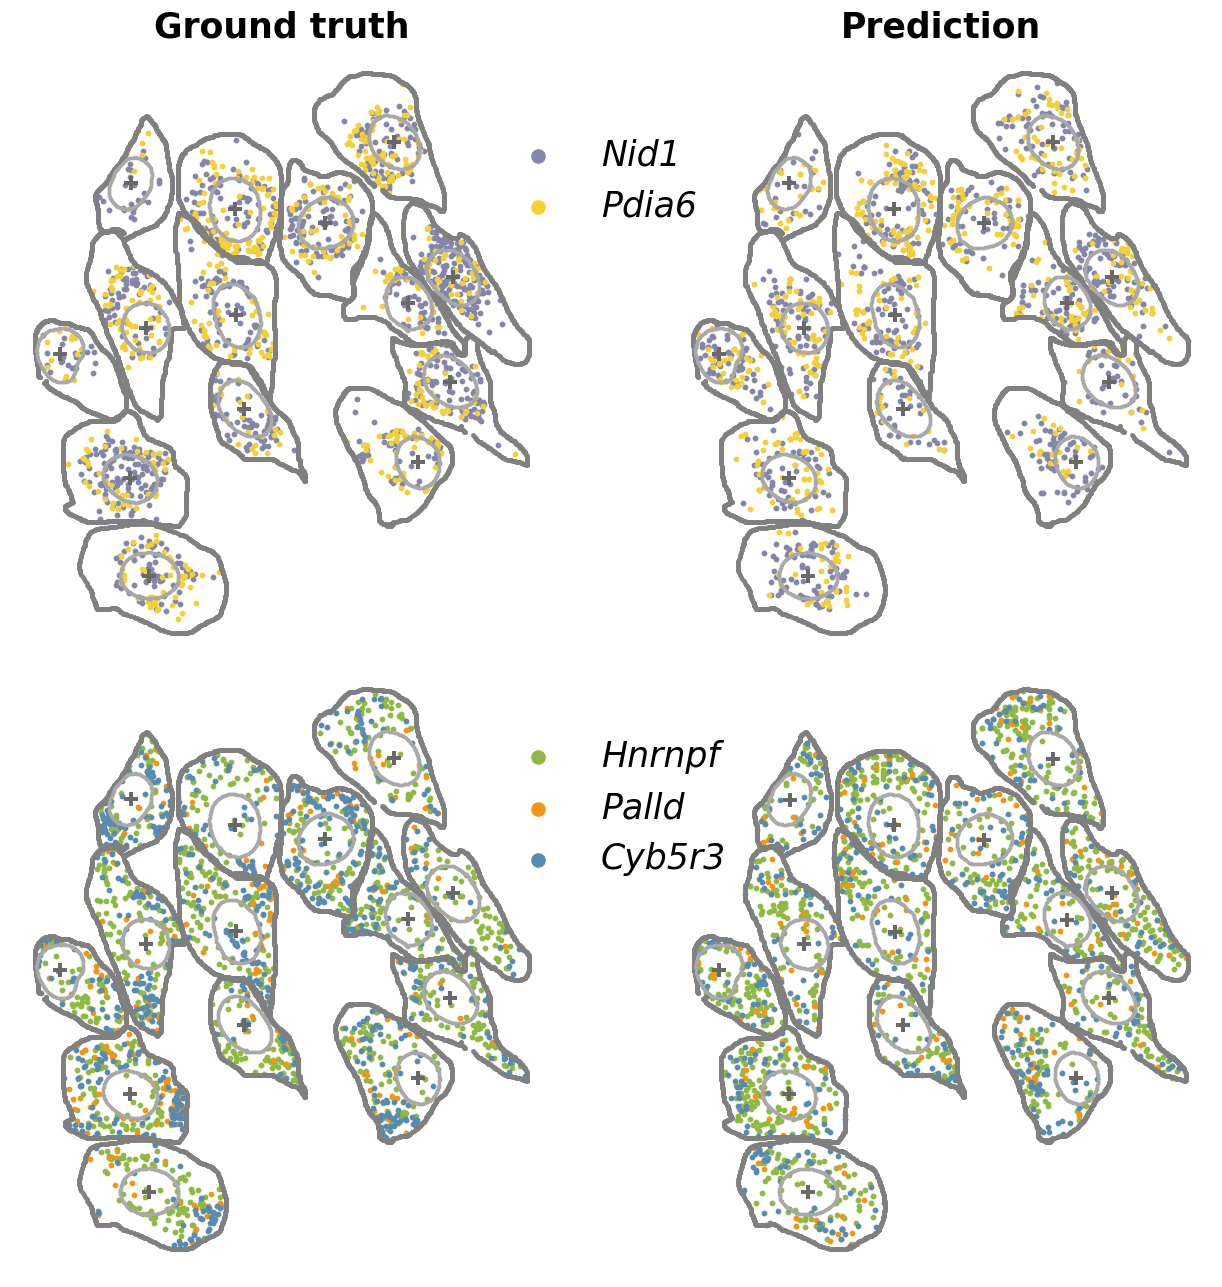

In [16]:
import matplotlib.patches as patches
non_zero_df_pred_exploded = non_zero_df_pred.loc[non_zero_df_pred.index.repeat(non_zero_df_pred['count'])].reset_index(drop=True)
fig, ax = plt.subplots(2, 2, figsize=(17, 16), gridspec_kw={'hspace': 0., 'wspace': 0}  # hspace 控制行间距，wspace 控制列间距
)
gene1 = 'Nid1'
gene2 = 'Pdia6'
transcript_filtered_gene1 = non_zero_df_pred_exploded[non_zero_df_pred_exploded['gene']==gene1]
transcript_filtered_gene2 = non_zero_df_pred_exploded[non_zero_df_pred_exploded['gene']==gene2]
truth_i = seqfish_data[preserve_idx_seqfish_data]
truth_i_gene1 = truth_i[truth_i['gene']==gene1]
truth_i_gene2 = truth_i[truth_i['gene']==gene2]

df_cell_contour_i = df_cell_contour[preserve_idx_cell_mask_contour]
df_nuclear_contour_i = df_nuclear_contour[preserve_idx_nuclear_mask_contour]

ax[0,0].scatter(df_cell_contour_i.x,df_cell_contour_i.y, color='grey', s=6,zorder=20)
ax[0,0].scatter(df_nuclear_contour_i.x,df_nuclear_contour_i.y, alpha=0.6, s=2,color='darkgrey',zorder=20)
ax[0,0].scatter(df_nuclear_contour_i['centerX'], df_nuclear_contour_i['centerY'], marker='+', color='dimgray', s=100,zorder=20)
ax[0,0].scatter(truth_i_gene1.x, truth_i_gene1.y, s=10, color = "#8386a8", label=gene1)
ax[0,0].scatter(truth_i_gene2.x, truth_i_gene2.y, s=10, color = "#f5cf36", label=gene2)
ax[0,0].set_aspect('equal')
ax[0,0].set_title(f'Ground truth', fontsize=25, fontweight='bold')
ax[0,0].axis('off')


ax[0,1].scatter(df_cell_contour_i.x,df_cell_contour_i.y, color='grey', s=6,zorder=20)
ax[0,1].scatter(df_nuclear_contour_i.x,df_nuclear_contour_i.y, alpha=0.6, s=2,color='darkgrey',zorder=20)
ax[0,1].scatter(df_nuclear_contour_i['centerX'], df_nuclear_contour_i['centerY'], marker='+', color='dimgray', s=100,zorder=20)
ax[0,1].scatter(transcript_filtered_gene1.x_original, transcript_filtered_gene1.y_original, s=10, color =  "#8386a8", label=gene1.capitalize())
ax[0,1].scatter(transcript_filtered_gene2.x_original, transcript_filtered_gene2.y_original, s=10, color = "#f5cf36", label=gene2.capitalize())

ax[0,1].set_aspect('equal')
ax[0,1].set_title(f'Prediction', fontsize=25, fontweight='bold')
leg = ax[0,0].legend( fontsize=25,markerscale=3,bbox_to_anchor=(0.85, 0.9),frameon=False)
for t in leg.get_texts():
    t.set_fontstyle('italic')
ax[0,1].axis('off')


gene1 = 'Hnrnpf'
gene2 = 'Palld'
gene3 = 'Cyb5r3'
non_zero_df_pred_exploded = non_zero_df_pred.loc[non_zero_df_pred.index.repeat(non_zero_df_pred['count'])].reset_index(drop=True)
transcript_filtered_gene1 = non_zero_df_pred_exploded[non_zero_df_pred_exploded['gene']==gene1]
transcript_filtered_gene2 = non_zero_df_pred_exploded[non_zero_df_pred_exploded['gene']==gene2]
transcript_filtered_gene3 = non_zero_df_pred_exploded[non_zero_df_pred_exploded['gene']==gene3]
truth_i = seqfish_data[preserve_idx_seqfish_data]
truth_i_gene1 = truth_i[truth_i['gene']==gene1]
truth_i_gene2 = truth_i[truth_i['gene']==gene2]
truth_i_gene3 = truth_i[truth_i['gene']==gene3]

df_cell_contour_i = df_cell_contour[preserve_idx_cell_mask_contour]
df_nuclear_contour_i = df_nuclear_contour[preserve_idx_nuclear_mask_contour]

ax[1,0].scatter(df_cell_contour_i.x,df_cell_contour_i.y, color='grey', s=6,zorder=20)
ax[1,0].scatter(df_nuclear_contour_i.x,df_nuclear_contour_i.y, alpha=0.6, s=2,color='darkgrey',zorder=20)
ax[1,0].scatter(df_nuclear_contour_i['centerX'], df_nuclear_contour_i['centerY'], marker='+', color='dimgray', s=100,zorder=20)
ax[1,0].scatter(truth_i_gene1.x, truth_i_gene1.y, s=10, color = "#8fb943", label=gene1.capitalize())
ax[1,0].scatter(truth_i_gene2.x, truth_i_gene2.y, s=10, color = "#f49512", label=gene2.capitalize())
ax[1,0].scatter(truth_i_gene3.x, truth_i_gene3.y, s=10, color = "#578bb2", label=gene3.capitalize())
ax[1,0].set_aspect('equal')
ax[1,0].axis('off')


ax[1,1].scatter(df_cell_contour_i.x,df_cell_contour_i.y, color='grey', s=6,zorder=20)
ax[1,1].scatter(df_nuclear_contour_i.x,df_nuclear_contour_i.y, alpha=0.6, s=2,color='darkgrey',zorder=20)
ax[1,1].scatter(df_nuclear_contour_i['centerX'], df_nuclear_contour_i['centerY'], marker='+', color='dimgray', s=100,zorder=20)
ax[1,1].scatter(transcript_filtered_gene1.x_original, transcript_filtered_gene1.y_original, s=10, color =  "#8fb943", label=gene1.capitalize())
ax[1,1].scatter(transcript_filtered_gene2.x_original, transcript_filtered_gene2.y_original, s=10, color = "#f49512", label=gene2.capitalize())
ax[1,1].scatter(transcript_filtered_gene3.x_original, transcript_filtered_gene3.y_original, s=10, color = "#578bb2", label=gene3.capitalize())

ax[1,1].set_aspect('equal')
leg = ax[1,0].legend(fontsize=25, markerscale=3, bbox_to_anchor=(0.85, 0.6),frameon=False)
for t in leg.get_texts():
    t.set_fontstyle('italic')
ax[1,1].axis('off')

plt.show()